In [21]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
#from Functions import prep_training_test_data_period, prep_training_test_data, calculate_ppv_npv
hfont = {'fontname':'Helvetica'}


# Get Data

In [22]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly.csv")

In [61]:
def prep_training_test_data_period(
    data, no_weeks, weeks_in_future, geography, weight_col, keep_output
):
    ## Get the weeks for the x and y datasets
    x_weeks = []
    y_weeks = []
    y_weeks_to_check = []  # check these weeks to see if any of them are equal to 1
    for week in no_weeks:
        test_week = int(week) + weeks_in_future
        x_weeks.append("_" + num2words(week) + "_")
        for week_y in range(week + 1, test_week + 1):
            y_weeks_to_check.append("_" + num2words(week_y) + "_")
        y_weeks.append("_" + num2words(test_week) + "_")

    ## Divide up the test/train split
    # if is_geographic:
    # Calculate the index to start slicing from
    #    start_index = len(data['county']) // proportion[0] * proportion[1]
    # Divide up the dataset based on this proportion
    #    first_two_thirds = data['county'][:start_index]
    #    last_third = data['county'][start_index:]
    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all = pd.DataFrame()
    missing_data = []
    ## Now get the training data
    k = 0
    for x_week in x_weeks:
        y_week = y_weeks[k]
        k += 1

        weeks_x = [col for col in data.columns if x_week in col]
        columns_x = [geography] + weeks_x + [weight_col]
        data_x = data[columns_x]

        weeks_y = [col for col in data.columns if y_week in col]
        columns_y = [geography] + weeks_y
        data_y = data[columns_y]
        ### now add the final column to the y data that has it so that it's if any week in the trhee week perdiod exceeded 15
        train_week = w2n.word_to_num(x_week.replace("_", ""))
        target_week = w2n.word_to_num(y_week.replace("_", ""))
        y_weeks_to_check = []
        for week_to_check in range(train_week + 1, target_week + 1):
            y_weeks_to_check.append("_" + num2words(week_to_check) + "_")

        y_weeks_to_check = [week + "beds_over_15_100k" for week in y_weeks_to_check]
        columns_to_check = [
            col for col in data.columns if any(week in col for week in y_weeks_to_check)
        ]
        y_over_in_period = data[columns_to_check].apply(max, axis=1)
        data_y = pd.concat([data_y, y_over_in_period], axis=1)
        # ensure they have the same amount of data
        # remove rows in test_data1 with NA in test_data2
        data_x = data_x.dropna()
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        # remove rows in test_data2 with NA in test_data1
        data_y = data_y.dropna()
        data_y = data_y[data_y[geography].isin(data_x[geography])]
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        data_x_no_HSA = len(data_x[geography].unique())

        missing_data.append(
            (
                (len(data[geography].unique()) - data_x_no_HSA)
                / len(data[geography].unique())
            )
            * 100
        )
        # get weights
        # weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

        X_week = data_x.iloc[:, 1 : len(columns_x)]  # take away y, leave weights for mo
        y_week = data_y.iloc[:, -1]

        y_week = y_week.astype(int)
        weights = X_week.iloc[:, -1]
        if keep_output:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 1
            ]  # remove the weights and leave "target" for that week

            # rename columns for concatenation
            X_week.columns = range(1, len(data_x.columns) - 1)
        else:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 2
            ]  # remove the weights and  "target" for that week

            X_week.columns = range(
                1, len(data_x.columns) - 2
            )  # remove the weights and  "target" for that week

        y_week.columns = range(1, len(data_y.columns) - 2)
        X_data = pd.concat([X_data, X_week])
        y_data = pd.concat([y_data, y_week])

        weights_all = pd.concat([weights_all, weights])

    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return (X_data, y_data, weights_all, missing_data)

def prep_training_test_data(
    data, no_weeks, weeks_in_future, geography, weight_col, keep_output
):
    ## Get the weeks for the x and y datasets
    x_weeks = []
    y_weeks = []
    for week in no_weeks:
        test_week = int(week) + weeks_in_future
        x_weeks.append("_" + num2words(week) + "_")
        y_weeks.append("_" + num2words(test_week) + "_")

    X_data = pd.DataFrame()
    y_data = pd.DataFrame()
    weights_all = pd.DataFrame()
    missing_data = []
    ## Now get the training data
    k = 0
    for x_week in x_weeks:
        y_week = y_weeks[k]
        k += 1
        weeks_x = [col for col in data.columns if x_week in col]
        columns_x = [geography] + weeks_x + [weight_col]
        data_x = data[columns_x]

        weeks_y = [col for col in data.columns if y_week in col]
        columns_y = [geography] + weeks_y
        data_y = data[columns_y]
        # ensure they have the same amount of data
        # remove rows in test_data1 with NA in test_data2
        data_x = data_x.dropna()
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        # remove rows in test_data2 with NA in test_data1
        data_y = data_y.dropna()
        data_y = data_y[data_y[geography].isin(data_x[geography])]
        data_x = data_x[data_x[geography].isin(data_y[geography])]
        data_x_no_HSA = len(data_x[geography].unique())

        missing_data.append(
            (
                (len(data[geography].unique()) - data_x_no_HSA)
                / len(data[geography].unique())
            )
            * 100
        )
        # get weights
        # weights = weight_data[weight_data[geography].isin(data_x[geography])][[geography, weight_col]]

        X_week = data_x.iloc[:, 1 : len(columns_x)]  # take away y, leave weights for mo
        y_week = data_y.iloc[:, -1]

        y_week = y_week.astype(int)
        weights = X_week.iloc[:, -1]
        if keep_output:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 1
            ]  # remove the weights and leave "target" for that week

            # rename columns for concatenation
            X_week.columns = range(1, len(data_x.columns) - 1)
        else:
            X_week = X_week.iloc[
                :, : len(X_week.columns) - 2
            ]  # remove the weights and  "target" for that week

            X_week.columns = range(
                1, len(data_x.columns) - 2
            )  # remove the weights and  "target" for that week

            # rename columns for concatenation
        y_week.columns = range(1, len(data_y.columns) - 1)
        X_data = pd.concat([X_data, X_week])
        y_data = pd.concat([y_data, y_week])

        weights_all = pd.concat([weights_all, weights])

    X_data.reset_index(drop=True, inplace=True)
    y_data.reset_index(drop=True, inplace=True)
    weights_all.reset_index(drop=True, inplace=True)

    return (X_data, y_data, weights_all, missing_data)

In [30]:
def cross_validation_leave_geo_out(data, geography_column, geo_split, no_iterations, cv, classifier, param_grid, no_iterations_param, no_weeks_train,no_weeks_test, weeks_in_future, weight_col, keep_output, time_period):
        best_hyperparameters_per_iter = []
        auROC_per_iter = []

        for i in range(no_iterations):
                #subset the HSAs from the full dataset 
                geo_names = data[geography_column].unique()
                num_names_to_select = int(geo_split * len(geo_names))
                geos_for_sample = random.sample(list(geo_names), num_names_to_select)
                subset_HSAs_for_train = data[data[geography_column].isin(geos_for_sample)]
                subset_HSAs_for_test = data[~data[geography_column].isin(geos_for_sample)]

                #create training and test data
                if time_period == 'period':
                        X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data_period(subset_HSAs_for_train, no_weeks = no_weeks_train, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data_period(subset_HSAs_for_test, no_weeks = no_weeks_test, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        weights_train = weights_train[0]
                elif time_period == 'exact':
                        X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data(subset_HSAs_for_train, no_weeks = no_weeks_train, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col =weight_col,keep_output = keep_output)
                        X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data(subset_HSAs_for_test, no_weeks = no_weeks_test, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        weights_train = weights_train[0]
                elif time_period == 'shifted':
                        X_sample_train, y_sample_train, weights_train, missing_data_train_HSA = prep_training_test_data_period(subset_HSAs_for_train, no_weeks = no_weeks_train, weeks_in_future = weeks_in_future, geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        X_sample_test, y_sample_test, weights_test, missing_data_train_HSA = prep_training_test_data_period(subset_HSAs_for_test, no_weeks = no_weeks_test, weeks_in_future = weeks_in_future,  geography = geography_column, weight_col = weight_col,keep_output = keep_output)
                        weights_train = weights_train[0]
                        y_sample_train = y_sample_train.shift(-1)
                        y_sample_test = y_sample_test.shift(-1)

                        y_sample_train.drop(index=y_sample_train.index[-1], inplace=True)
                        y_sample_test.drop(index=y_sample_test.index[-1], inplace=True)

                        X_sample_train.drop(index=X_sample_train.index[-1], inplace=True)
                        X_sample_test.drop(index=X_sample_test.index[-1], inplace=True)

                        weights_train.drop(index=weights_train.index[-1], inplace=True)
                random_search = RandomizedSearchCV(classifier, param_grid, n_iter=no_iterations_param, cv=cv, random_state=10)
                random_search.fit(X_sample_train, y_sample_train, sample_weight = weights_train)
                best_params = random_search.best_params_

        # Create the Decision Tree classifier with the best hyperparameters
                model = DecisionTreeClassifier(**best_params,random_state=10, class_weight='balanced')
                model_fit = model.fit(X_sample_train, y_sample_train, sample_weight=weights_train)
                y_pred = model_fit.predict_proba(X_sample_test)
                # Evaluate the accuracy of the model
                best_hyperparameters_per_iter.append(best_params)
                auROC_per_iter.append(roc_auc_score(y_sample_test, y_pred[:,1]))
        
        return best_hyperparameters_per_iter[np.argmax(np.array(auROC_per_iter))]


# Get data

In [25]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly.csv")

CDC Data

In [26]:
columns_to_select = HSA_weekly_data_all.filter(regex="HSA|cases|perc_covid|admits|beds_over_15_100k|weight").columns.tolist()
columns_to_select = [col for col in columns_to_select if "delta" not in col]

CDC_data = HSA_weekly_data_all[columns_to_select]

# Global parameters needed for hyperparameter tuning

In [67]:
no_iterations = 100  
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'exact'  # Choose 'period', 'exact', or 'shifted'
no_weeks_train =  range(1, int(26) + 1)  # First 6 months initially 
no_weeks_test = range(26, int(26 + 13) + 1)  # Next three months
weeks_in_future = 3 
weight_col = 'weight'  
keep_output = False  
no_iterations_param = 50  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 20, 2),
    'min_samples_split': np.arange(200, 2000, 50), #[100, 200, 300, 400, 500], #np.arange(50, 200),
    'min_samples_leaf':  np.arange(200, 2000, 50)} #100, 200, 300, 400, 500], #np.arange(500, 200)
    #'ccp_alpha': np.arange(0.0001, 0.0035, 0.0001) }

# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

# CDC Classifier 
- Train on 6 months, test on 3 months

In [28]:
clf_exact = DecisionTreeClassifier(random_state=10, class_weight='balanced')

In [41]:
best_params = cross_validation_leave_geo_out(CDC_data, geography_column = geography_column, geo_split = geo_split, no_iterations = no_iterations, cv = cv, classifier = clf_exact, param_grid = param_grid, no_iterations_param = no_iterations_param, no_weeks_train = no_weeks_train,no_weeks_test = no_weeks_test, weeks_in_future = weeks_in_future, weight_col = weight_col, keep_output = keep_output, time_period = time_period)

In [45]:
X_train_CDC_exact, y_train_CDC_exact, weights_CDC_exact, missing_data_train_HSA = prep_training_test_data(CDC_data,  no_weeks = range(1, int(26) + 1), weeks_in_future =  3, geography = 'HSA_ID', weight_col = 'weight', keep_output = False)

X_test_CDC_exact, y_test_CDC_exact, weights_test_CDC_exact, missing_data_test_HSA = prep_training_test_data(CDC_data,  no_weeks = range(int(26) + 1, 26+13 + 1), weeks_in_future =  3, geography = 'HSA_ID',  weight_col = 'weight', keep_output = False)
weights_CDC_exact = weights_CDC_exact[0].to_numpy()

In [48]:
clf_exact = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')
clf_exact.fit(X_train_CDC_exact, y_train_CDC_exact,  sample_weight = weights_CDC_exact)

# Make predictions on the test set
y_pred = clf_exact.predict(X_test_CDC_exact)
y_pred_proba = clf_exact.predict_proba(X_test_CDC_exact)

# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test_CDC_exact, y_pred)
ROC = roc_auc_score(y_test_CDC_exact, y_pred_proba[:,1])

[Text(0.3225806451612903, 0.9375, 'perc_covid <= 0.016\nentropy = 1.0\nsamples = 20778\nvalue = [12.938, 12.938]'),
 Text(0.1935483870967742, 0.8125, 'perc_covid <= 0.007\nentropy = 0.591\nsamples = 4769\nvalue = [10.143, 1.689]'),
 Text(0.12903225806451613, 0.6875, 'cases <= 42.5\nentropy = 0.469\nsamples = 3395\nvalue = [8.606, 0.955]'),
 Text(0.06451612903225806, 0.5625, 'entropy = 0.297\nsamples = 1389\nvalue = [4.356, 0.241]'),
 Text(0.1935483870967742, 0.5625, 'entropy = 0.594\nsamples = 2006\nvalue = [4.25, 0.713]'),
 Text(0.25806451612903225, 0.6875, 'entropy = 0.908\nsamples = 1374\nvalue = [1.537, 0.734]'),
 Text(0.45161290322580644, 0.8125, 'admits <= 4.57\nentropy = 0.72\nsamples = 16009\nvalue = [2.795, 11.249]'),
 Text(0.3870967741935484, 0.6875, 'entropy = 1.0\nsamples = 2212\nvalue = [1.389, 1.375]'),
 Text(0.5161290322580645, 0.6875, 'perc_covid <= 0.049\nentropy = 0.542\nsamples = 13797\nvalue = [1.406, 9.874]'),
 Text(0.3548387096774194, 0.5625, 'perc_covid <= 0.031\

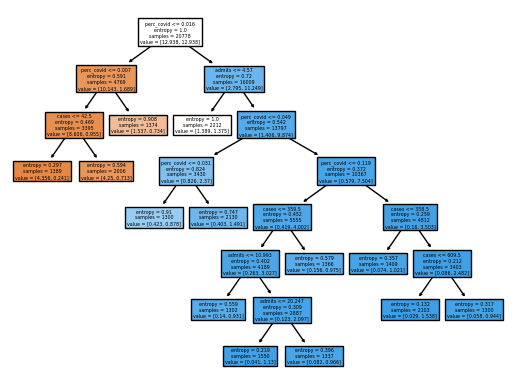

In [51]:
plot_tree(clf_exact, feature_names=['cases', 'admits','perc_covid'], filled=True)


Classifiers by week 

In [56]:
weeks_to_predict = range(1,121)
ROC_by_week = []
sensitivity_by_week = []
specificity_by_week = []
ppv_by_week = []
npv_by_week = []
accuracy_by_week = []

#
for prediction_week in weeks_to_predict: 
    
    X_train_CDC_exact, y_train_CDC_exact, weights_CDC_exact, missing_data_train_HSA = prep_training_test_data(CDC_data,  no_weeks = range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future =  3, geography = 'HSA_ID', weight_col = 'weight', keep_output = False)

    X_test_CDC_exact, y_test_CDC_exact, weights_test_CDC_exact, missing_data_test_HSA = prep_training_test_data(CDC_data,  no_weeks = range(int(prediction_week + 26) + 1, int(prediction_week +26 + 13) + 1), weeks_in_future =  3, geography = 'HSA_ID',  weight_col = 'weight', keep_output = False)
    weights_CDC_exact = weights_CDC_exact[0].to_numpy()
    best_params = cross_validation_leave_geo_out(CDC_data, geography_column = geography_column, geo_split = geo_split, no_iterations = no_iterations, cv = cv, classifier = clf_exact, param_grid = param_grid, no_iterations_param = no_iterations_param, no_weeks_train = no_weeks_train,no_weeks_test = no_weeks_test, weeks_in_future = weeks_in_future, weight_col = weight_col, keep_output = keep_output, time_period = time_period)
    clf_exact = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')
    clf_exact.fit(X_train_CDC_exact, y_train_CDC_exact,  sample_weight = weights_CDC_exact)

    # Make predictions on the test set
    y_pred = clf_exact.predict(X_test_CDC_exact)
    y_pred_proba = clf_exact.predict_proba(X_test_CDC_exact)


    # Evaluate the accuracy of the model
    accuracy_by_week.append(accuracy_score(y_test_CDC_exact, y_pred))
    ROC_by_week.append(roc_auc_score(y_test_CDC_exact, y_pred_proba[:,1]))
    conf_matrix = confusion_matrix(y_test_CDC_exact, y_pred)

    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]

    # Calculate specificity (true negative rate)
    specificity_by_week.append(TN / (TN + FP))
    # Calculate sensitivity (true positive rate)
    sensitivity_by_week.append(TP / (TP + FN))

    ppv, npv = calculate_ppv_npv(conf_matrix)
    ppv_by_week.append(ppv)
    npv_by_week.append(npv)

# Full classifier 

In [59]:
clf_full_period = DecisionTreeClassifier(random_state=10, class_weight='balanced')

In [63]:
weeks_to_predict = range(1, 121 - 13)
ROC_by_week_full_period= []
sensitivity_by_week_full_period = []
specificity_by_week_full_period = []
ppv_by_week_full_period = []
npv_by_week_full_period = []
accuracy_by_week_full_period = []

for prediction_week in weeks_to_predict:
    print(prediction_week)
    X_train_CDC_full_period, y_train_CDC_full_period, weights_CDC_full_period, missing_data_train_HSA = prep_training_test_data_period(CDC_data, no_weeks=range(prediction_week, int(prediction_week + 26) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=False)

    X_test_CDC_full_period, y_test_CDC_full_period, weights_test_CDC_full_period, missing_data_test_HSA = prep_training_test_data_period(CDC_data, no_weeks=range(int(prediction_week + 26) + 1, int(prediction_week + 26 + 13) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=False)
    weights_CDC_full_period = weights_CDC_full_period[0].to_numpy()
    best_params = cross_validation_leave_geo_out(CDC_data, geography_column=geography_column, geo_split=geo_split, no_iterations=no_iterations, cv=cv, classifier=clf_full_period, param_grid=param_grid, no_iterations_param=no_iterations_param, no_weeks_train=no_weeks_train, no_weeks_test=no_weeks_test, weeks_in_future=weeks_in_future, weight_col=weight_col, keep_output=keep_output, time_period='period')
    clf_full_period = DecisionTreeClassifier(**best_params, random_state=10, class_weight='balanced')
    clf_full_period.fit(X_train_CDC_full_period, y_train_CDC_full_period, sample_weight=weights_CDC_full_period)

    # Make predictions on the test set
    y_pred = clf_full_period.predict(X_test_CDC_full_period)
    y_pred_proba = clf_full_period.predict_proba(X_test_CDC_full_period)

    # Evaluate the accuracy of the model
    accuracy_by_week_full_period.append(accuracy_score(y_test_CDC_full_period, y_pred))
    ROC_by_week_full_period.append(roc_auc_score(y_test_CDC_full_period, y_pred_proba[:, 1]))
    conf_matrix = confusion_matrix(y_test_CDC_full_period, y_pred)

    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]
    TP = conf_matrix[1, 1]

    # Calculate specificity (true negative rate)
    specificity_by_week_full_period.append(TN / (TN + FP))
    # Calculate sensitivity (true positive rate)
    sensitivity_by_week_full_period.append(TP / (TP + FN))

    ppv, npv = calculate_ppv_npv(conf_matrix)
    ppv_by_week_full_period.append(ppv)
    npv_by_week_full_period.append(npv)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [65]:
ROC_by_week[-21:]

[0.8316435102104571,
 0.9053817147330336,
 0.898704329510008,
 0.894587513508454,
 0.8896956131956686,
 0.8855972088003112,
 0.8707943626492947,
 0.8673684490855537,
 0.8684875070999597,
 0.8656116773935867,
 0.865075778489627,
 0.8601233634124343,
 0.8573706707276318,
 0.8432679507431045,
 0.8340486504364412,
 0.8269451223288588,
 0.8278981166519035,
 0.8565979719195147,
 0.8387188192637733,
 0.8484304810416429,
 0.8649076402974983]